In [9]:
# ======================================
# 0. Core libs (DAY1~DAY9 공통)
# ======================================
import numpy as np
import pandas as pd

import shutil
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import matplotlib.font_manager as fm
from matplotlib import rcParams

# ======================================
# 1) Style FIRST (폰트보다 먼저)
# ======================================
plt.style.use("_mpl-gallery-nogrid")
sns.set_theme(style="white")
sns.set_style("ticks")
sns.set_context("notebook")

# ======================================
# 2) Font (NanumGothic) — style 적용 후 "고정"
# ======================================
FONT_DIR = Path(r"E:\Portfolio_ver1\seoul_pv_load_analysis\fonts")
FONT_PATH = FONT_DIR / "NanumGothic.ttf"

if not FONT_PATH.exists():
    raise FileNotFoundError(f"폰트 파일 없음: {FONT_PATH}")

fm.fontManager.addfont(str(FONT_PATH))
font_name = fm.FontProperties(fname=str(FONT_PATH)).get_name()

rcParams["font.family"] = font_name
rcParams["axes.unicode_minus"] = False

# (선택) 기본 글자 크기 통일
rcParams["font.size"] = 12
rcParams["axes.titlesize"] = 18
rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12

# 개별 객체용 (필요할 때만)
font_prop = fm.FontProperties(fname=str(FONT_PATH))

print("✅ Style+Font ready:", font_name)

✅ Style+Font ready: NanumGothic


In [10]:
# -------------------------
# 0) Load CSV (auto-find project root by /data)
# -------------------------
cwd = Path.cwd()
PROJECT_ROOT = None
for p in [cwd, *cwd.parents]:
    if (p / "data").exists():
        PROJECT_ROOT = p
        break
if PROJECT_ROOT is None:
    raise FileNotFoundError("data 폴더를 찾지 못했습니다. notebooks 폴더에서 실행하거나 경로를 확인하세요.")

DATA_DIR = PROJECT_ROOT / "data"
LOAD_FILE = DATA_DIR / "법정동별시간별전력사용량.csv"

df_raw = pd.read_csv(LOAD_FILE)

print("Loaded:", LOAD_FILE.name)
print("Columns:", df_raw.columns.tolist())

# -------------------------
# 1) Build datetime (robust)
# -------------------------
if "datetime" in df_raw.columns:
    df_raw["datetime"] = pd.to_datetime(df_raw["datetime"], errors="coerce")

else:
    # 후보 컬럼 자동 탐지
    date_candidates = [c for c in df_raw.columns if c.upper() in ["USE_YM", "USE_DT", "USE_YMD", "DATE", "DT", "YMD"]]
    time_candidates = [c for c in df_raw.columns if c.upper() in ["USE_HM", "TIME", "HM", "HOUR", "HH"]]

    if not date_candidates or not time_candidates:
        raise KeyError(
            "datetime 생성용 날짜/시간 컬럼을 못 찾았어.\n"
            f"- date 후보: {date_candidates}\n"
            f"- time 후보: {time_candidates}\n"
            f"현재 컬럼: {df_raw.columns.tolist()}"
        )

    date_col = date_candidates[0]
    time_col = time_candidates[0]

    # 숫자만 추출
    date_str = df_raw[date_col].astype(str).str.replace(r"\D", "", regex=True)
    time_str = df_raw[time_col].astype(str).str.replace(r"\D", "", regex=True)

    # date는 YYYYMMDD(8) 또는 YYYYMM(6) 가정
    mode_len = int(date_str.str.len().mode().iloc[0])
    if mode_len == 6:
        # YYYYMM -> YYYYMM01
        date_str = date_str + "01"
    elif mode_len == 8:
        pass
    else:
        # 방어: 길이가 섞여 있으면 6/8 둘 다 처리 시도
        date_str = np.where(date_str.str.len() == 6, date_str + "01", date_str)
        date_str = pd.Series(date_str)

    # time은 HHMM로 맞추기 (예: 1 -> 0001이 아니라 '01:00'일 수도 있으니 규칙을 분기)
    # 케이스 A) 값이 100, 200, ..., 2300, 2400 형태 (HHMM)
    # 케이스 B) 값이 1~24 형태 (hour)
    # -> 숫자 범위를 보고 분기
    time_num = pd.to_numeric(time_str, errors="coerce")

    # 기본 hour/minute 추출
    # HHMM 형태 가능성이 높으면 (>=100 이거나 0 포함) HHMM로 해석
    is_hhmm = (time_num.dropna() >= 100).mean() > 0.5

    if is_hhmm:
        hh = (time_num // 100).astype("Int64")
        mm = (time_num % 100).astype("Int64")
    else:
        # hour 형태(1~24 or 0~23)로 해석, 분은 0
        hh = time_num.astype("Int64")
        mm = pd.Series([0] * len(df_raw), index=df_raw.index).astype("Int64")

    # 2400(=24:00) 처리: 00:00로 바꾸고 다음날 +1일
    add_day = (hh == 24) & (mm == 0)
    hh = hh.where(~add_day, 0)

    # date 파싱
    date_dt = pd.to_datetime(date_str, format="%Y%m%d", errors="coerce")

    # datetime 생성 (분 단위까지)
    dt = date_dt + pd.to_timedelta(hh.fillna(0), unit="h") + pd.to_timedelta(mm.fillna(0), unit="m")
    dt = dt + pd.to_timedelta(add_day.fillna(False).astype(int), unit="D")

    df_raw["datetime"] = dt

# -------------------------
# 2) Clean + Base cols
# -------------------------
df = df_raw.dropna(subset=["datetime"]).copy()
df["hour"] = df["datetime"].dt.hour
df["month"] = df["datetime"].dt.month

# -------------------------
# 3) Standardize load column -> value
# -------------------------
if "value" not in df.columns:
    if "FDRCT_VLD_KWH" in df.columns:
        df["value"] = pd.to_numeric(df["FDRCT_VLD_KWH"], errors="coerce")
    else:
        raise KeyError("부하 컬럼을 못 찾았어. 'value' 또는 'FDRCT_VLD_KWH' 필요.")

df = df.dropna(subset=["value"]).copy()

print("Rows:", len(df))
print("Datetime range:", df["datetime"].min(), "~", df["datetime"].max())
print("Hour range:", df["hour"].min(), "~", df["hour"].max())
print("Month range:", df["month"].min(), "~", df["month"].max())

df[["datetime", "hour", "month", "value"]].head(3)

Loaded: 법정동별시간별전력사용량.csv
Columns: ['SIGUNGU_CD', 'BJDONG_CD', 'USE_YM', 'USE_HM', 'FDRCT_VLD_KWH']
Rows: 9754804
Datetime range: 2022-06-28 01:00:00 ~ 2024-01-29 00:00:00
Hour range: 0 ~ 23
Month range: 1 ~ 12


,datetime,hour,month,value
0,2022-06-28 01:00:00,1,6,10782.0565
1,2022-06-28 01:00:00,1,6,11394.8635
2,2022-06-28 01:00:00,1,6,7273.9620


In [4]:
# 1. spatial column pick
spatial_col = "BJDONG_CD" # 법정동 기준 (DAY 10 공간 축)
load_col = "value" # 표준화 완료

# 2. 공간 컬럼 존재 확인
if spatial_col not in df.columns:
    raise KeyError(f"'{spatial_col}' 컬럼이 없습니다. 현재 컬럼: {df.columns.tolist()}")

print("Unique regions:", df[spatial_col].nunique())
df[[spatial_col, "hour", load_col]].head()

Unique regions: 87


,BJDONG_CD,hour,value
0,10700,1,10782.0565
1,10800,1,11394.8635
2,10900,1,7273.9620
3,10300,1,11008.8110
4,11300,1,2905.1120


In [5]:
# 2. 법정동별 24H 프로파일 + ABC 타입 생성
# Hourly profile + ABC typing
EV_START, EV_END = 18, 22
DAY_START, DAY_END = 10, 16

# 시간대별 평균 부하(법정동 - 시간)
hourly_profile = (df.groupby([spatial_col, "hour"])[load_col].mean().reset_index(name = "avg_load"))

# 법정동별 총합(24H 기준)
total = hourly_profile.groupby(spatial_col)["avg_load"].sum().rename("total").reset_index()

evening = (hourly_profile[(hourly_profile["hour"] >= EV_START) & (hourly_profile["hour"] <= EV_END)]
           .groupby(spatial_col)["avg_load"].sum().rename("evening_sum").reset_index())

day = (hourly_profile[(hourly_profile["hour"] >= DAY_START) & (hourly_profile["hour"] <= DAY_END)]
       .groupby(spatial_col)["avg_load"].sum().rename("day_sum").reset_index())

region = (total.merge(evening, on = spatial_col, how = "left").merge(day, on = spatial_col, how = "left").fillna(0))

region["evening_share"] = region["evening_sum"] / region["total"]
region["day_share"] = region["day_sum"] / region["total"]

# 분포 기반 임계값
ev_th = region["evening_share"].quantile(0.67)
day_th = region["day_share"].quantile(0.67)

def classfy_abc(row):
    if row["evening_share"] >= ev_th:
        return "B" # Evening_critical
    elif row["day_share"]  >= day_th:
        return "A" #PV 친화적
    else:
        return "C" # A + B mixed
    
region["ABC_type"] = region.apply(classfy_abc, axis = 1)

print("Thresholds:", {"evenong_share_67%": ev_th, "day_share_67%": day_th})
region[["BJDONG_CD", "evening_share", "day_share", "ABC_type"]].head()

Thresholds: {'evenong_share_67%': np.float64(0.2342573260803223), 'day_share_67%': np.float64(0.3787900653094563)}


,BJDONG_CD,evening_share,day_share,ABC_type
0,10100,0.227742,0.377968,C
1,10200,0.228742,0.367588,C
2,10300,0.234056,0.333712,C
3,10400,0.237463,0.356497,B
4,10500,0.229396,0.356954,C


In [16]:
# LOAD 
dong = pd.read_csv(DATA_DIR / "국토교통부_전국 법정동_20250807.csv")

# 10자리 키 만들기
dong["BJDONG_10"] = dong["법정동코드"].astype(str).str.replace(r"\D", "", regex = True).str.zfill(10)

# 표시용 동이름 만들기: 읍면동명
dong["BJDONG_NM"] = (dong["읍면동명"].astype(str).str.strip() +
                     np.where(dong["리명"].isna() | (dong["리명"].astype(str).str.strip() == ""),"", " " + dong["리명"].astype(str).str.strip()))

# 구 이름(시군구명)
dong = dong.rename(columns = {"시군구명": "GU_NM", "시도명": "SIDO_NM"})

# 삭제일자가 빈 값/NaN인 것 만 남기기
dong_clean = dong[dong["삭제일자"].isna()].copy()

dong_clean[["BJDONG_10", "SIDO_NM", "GU_NM", "BJDONG_NM"]].head()

,BJDONG_10,SIDO_NM,GU_NM,BJDONG_NM
0,1100000000,서울특별시,NaN,nan
1,1111000000,서울특별시,종로구,nan
2,1111010100,서울특별시,종로구,청운동
3,1111010200,서울특별시,종로구,신교동
4,1111010300,서울특별시,종로구,궁정동


In [17]:
# 법정동 10자리 키 만들기 (전력사용량 df)
df["SIGUNGU_5"] = df["SIGUNGU_CD"].astype(str).str.zfill(5)
df["BJDONG_5"] = df["BJDONG_CD"].astype(str).str.zfill(5)
df["BJDONG_10"] = df["SIGUNGU_5"] + df["BJDONG_5"]

In [19]:
# merge 해서 동 이름 붙이기
df_named = df.merge(dong_clean[["BJDONG_10", "SIDO_NM", "GU_NM", "BJDONG_NM"]], on = "BJDONG_10", how = "left")

# 매칭 검증
miss = df_named["BJDONG_NM"].isna().mean()
print(f"동 이름 매칭 실패 비율: {miss:.2%}")

df_named[["BJDONG_10", "GU_NM", "BJDONG_NM", "hour", "value"]].head()

동 이름 매칭 실패 비율: 0.00%


,BJDONG_10,GU_NM,BJDONG_NM,hour,value
0,1165010700,서초구,반포동,1,10782.0565
1,1165010800,서초구,서초동,1,11394.8635
2,1165010900,서초구,내곡동,1,7273.9620
3,1174010300,강동구,상일동,1,11008.8110
4,1171011300,송파구,거여동,1,2905.1120


In [20]:
#  구 단위 24h 프로파일 + ABC 타입 분류
spatial_col = "GU_NM"
load_col = "value"

EV_START, EV_END = 18, 22
DAY_START, DAY_END = 10, 16

# 구 - 시간대 평균 부하
gu_hourly = (df_named.groupby([spatial_col, "hour"])[load_col].mean().reset_index(name = "avg_load"))

# 구별 총합
total = gu_hourly.groupby(spatial_col)["avg_load"].sum().rename("total").reset_index()

# Evening / Daytime
evening = (gu_hourly[(gu_hourly["hour"] >= EV_START) & (gu_hourly["hour"] <= EV_END)]
           .groupby(spatial_col)["avg_load"].sum().rename("evening_sum").reset_index())

day = (gu_hourly[(gu_hourly["hour"] >= DAY_START) & (gu_hourly["hour"] <= DAY_END)]
       .groupby(spatial_col)["avg_load"].sum().rename("day_sum").reset_index())

# 병합
gu = (total.merge(evening, on = spatial_col, how = "left")
      .merge(day, on = spatial_col, how = "left").fillna(0))

gu["evening_share"] = gu["evening_sum"] / gu["total"]
gu["day_share"] = gu["day_sum"] / gu["total"]

# 분포 기반 임계값
ev_th = gu["evening_share"].quantile(0.67)
day_th = gu["day_share"].quantile(0.67)

def classify_abc(row):
    if row["evening_share"] >= ev_th:
        return "B" # Evening critical
    elif row["day_share"] >= day_th:
        return "A" # PV friendly
    else:
        return "C" # Mixed
    
gu["ABC_type"] = gu.apply(classify_abc, axis = 1)

gu.sort_values("evening_share", ascending = False).head()

,GU_NM,total,evening_sum,day_sum,evening_share,day_share,ABC_type
18,양천구,110911.045397,27508.210659,38686.386518,0.248020,0.348806,B
8,노원구,240196.122205,59090.523467,81648.395469,0.246009,0.339924,B
5,광진구,232634.208103,56443.393436,79758.734567,0.242627,0.342850,B
24,중랑구,130924.823452,31708.901509,43362.797753,0.242192,0.331204,B
9,도봉구,161308.549745,38548.671381,53833.424817,0.238975,0.333730,B


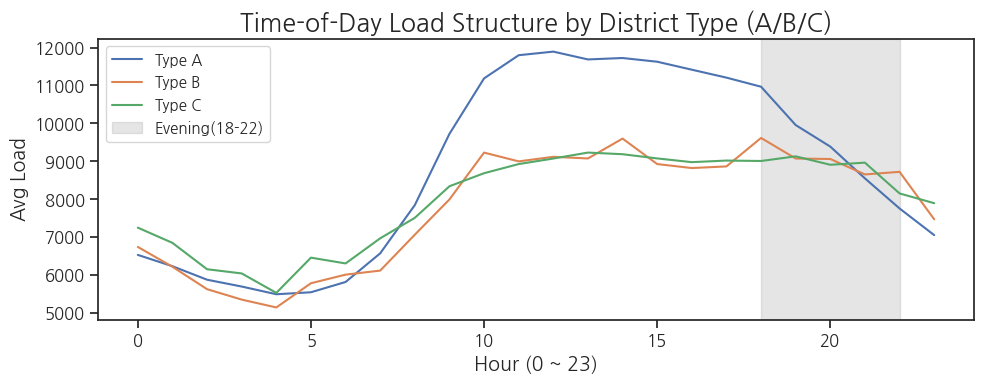

In [22]:
# 메인 그래프: 타입별 평균 24h 곡선
gu_typed = gu_hourly.merge(gu[[spatial_col, "ABC_type"]], on = spatial_col, how = "left")
type_profile = (gu_typed.groupby(["ABC_type", "hour"])["avg_load"].mean().reset_index())

plt.figure(figsize = (10, 4))
for t in ["A", "B", "C"]:
    temp = type_profile[type_profile["ABC_type"] == t]
    plt.plot(temp["hour"], temp["avg_load"], label = f"Type {t}")

plt.axvspan(EV_START, EV_END, color = "gray", alpha = 0.2, label = "Evening(18-22)")
plt.xlabel("Hour (0 ~ 23)")
plt.ylabel("Avg Load")
plt.title("Time-of-Day Load Structure by District Type (A/B/C)")
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
# 공통 설정
EV_START, EV_END = 18, 22
DAY_START, DAY_END = 10, 16

load_col = "value"
gu_col   = "GU_NM"
dong_col = "BJDONG_NM"

In [27]:
# 타입 별 구 리스트
typeA_gus = gu.loc[gu["ABC_type"] == "A", gu_col].tolist()
typeB_gus = gu.loc[gu["ABC_type"] == "B", gu_col].tolist()
typeC_gus = gu.loc[gu["ABC_type"] == "C", gu_col].tolist()

In [28]:
# 타입 별 데이터 분리
df_A = df_named[df_named[gu_col].isin(typeA_gus)].copy()
df_B = df_named[df_named[gu_col].isin(typeB_gus)].copy()
df_C = df_named[df_named[gu_col].isin(typeC_gus)].copy()

In [29]:
# A type 대표동 3곳
dong_A = (
    df_A.groupby(dong_col)
        .apply(lambda x: x.loc[x["hour"].between(DAY_START, DAY_END), load_col].sum()
                        / x[load_col].sum())
        .rename("day_share")
        .reset_index()
        .sort_values("day_share", ascending=False)
)

sample_A = dong_A.head(3)[dong_col].tolist()
sample_A

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_8964\903786759.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x["hour"].between(DAY_START, DAY_END), load_col].sum()


['입정동', '장사동', '남대문로3가']

In [30]:
# B type 대표동 3곳
dong_B = (
    df_B.groupby(dong_col)
        .apply(lambda x: x.loc[x["hour"].between(EV_START, EV_END), load_col].sum()
                        / x[load_col].sum())
        .rename("evening_share")
        .reset_index()
        .sort_values("evening_share", ascending=False)
)

sample_B = dong_B.head(3)[dong_col].tolist()
sample_B

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_8964\737241025.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x["hour"].between(EV_START, EV_END), load_col].sum()


['중계동', '묵동', '금호동3가']

In [31]:
# C type 대표동 3곳
dong_C = (
    df_C.groupby(dong_col)
        .apply(lambda x: pd.Series({
            "day_share": x.loc[x["hour"].between(DAY_START, DAY_END), load_col].sum()
                         / x[load_col].sum(),
            "evening_share": x.loc[x["hour"].between(EV_START, EV_END), load_col].sum()
                             / x[load_col].sum()
        }))
        .reset_index()
)

dong_C["balance"] = (dong_C["day_share"] - dong_C["evening_share"]).abs()

sample_C = dong_C.sort_values("balance").head(3)[dong_col].tolist()
sample_C

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_8964\1687866566.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


['현석동', '항동', '하중동']

In [32]:
def plot_sample_dongs(df_src, sample_dongs, title):
    hourly = (
        df_src.groupby([dong_col, "hour"])[load_col]
              .mean()
              .reset_index(name="avg_load")
    )
    
    plt.figure(figsize=(10,4))
    for d in sample_dongs:
        temp = hourly[hourly[dong_col] == d]
        plt.plot(temp["hour"], temp["avg_load"], label=d)

    plt.axvspan(EV_START, EV_END, color="gray", alpha=0.2)
    plt.xlabel("Hour")
    plt.ylabel("Avg Load")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

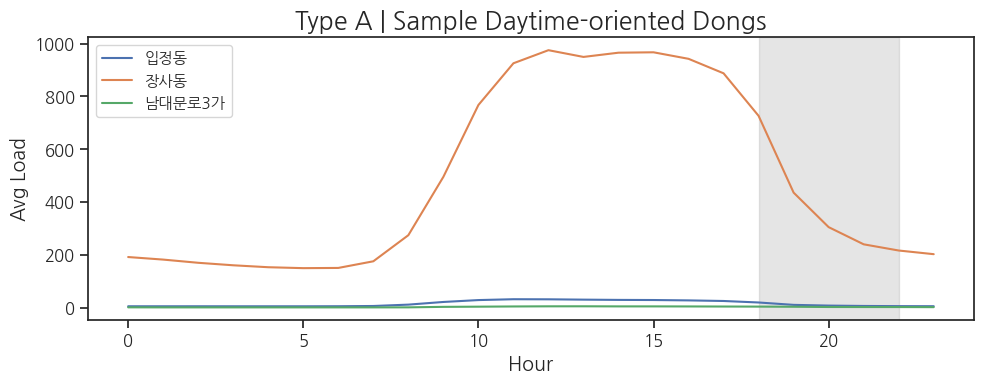

In [33]:
plot_sample_dongs(df_A, sample_A, "Type A | Sample Daytime-oriented Dongs")

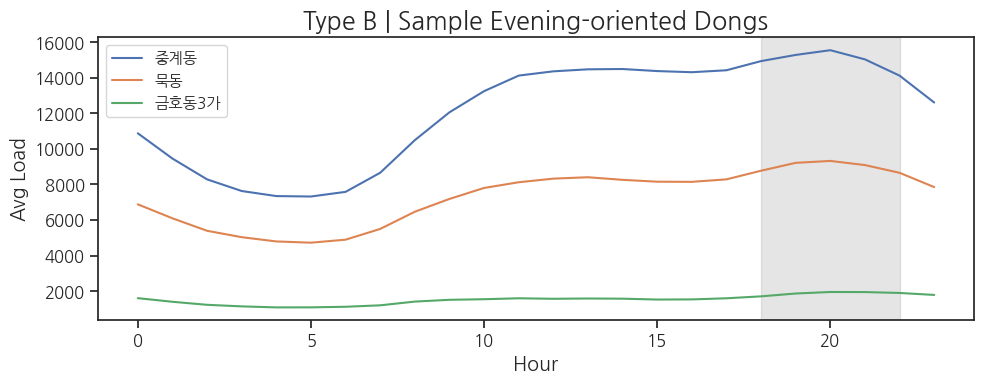

In [34]:
plot_sample_dongs(df_B, sample_B, "Type B | Sample Evening-oriented Dongs")

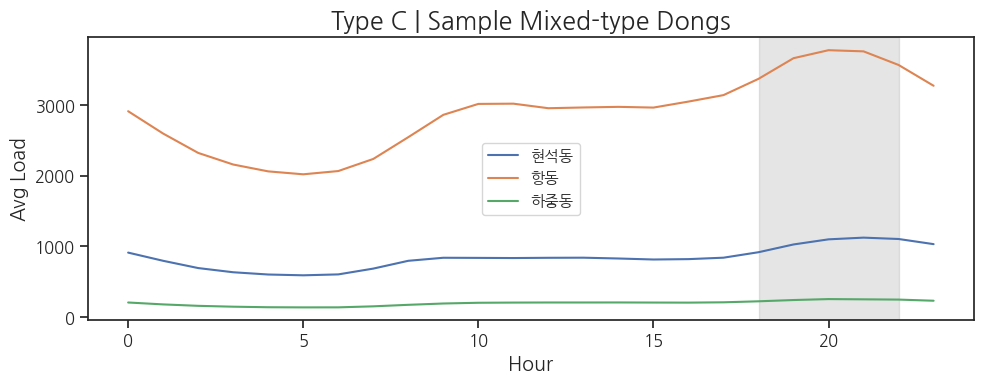

In [35]:
plot_sample_dongs(df_C, sample_C, "Type C | Sample Mixed-type Dongs")

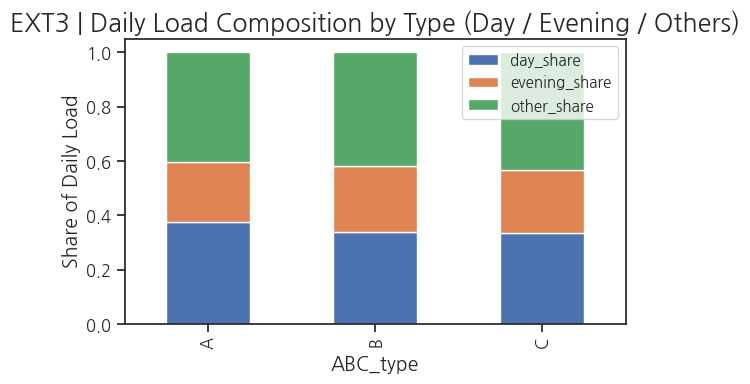

In [36]:
# 타입별 평균 비중 요약
type_summary = (
    gu.groupby("ABC_type")[["day_share", "evening_share"]]
      .mean()
      .reset_index()
)

type_summary["other_share"] = 1 - type_summary["day_share"] - type_summary["evening_share"]

# 정렬(A,B,C)
order = ["A","B","C"]
type_summary["ABC_type"] = pd.Categorical(type_summary["ABC_type"], categories=order, ordered=True)
type_summary = type_summary.sort_values("ABC_type").set_index("ABC_type")

# Plot
ax = type_summary[["day_share","evening_share","other_share"]].plot(
    kind="bar", stacked=True, figsize=(6,4)
)
plt.ylabel("Share of Daily Load")
plt.title("EXT3 | Daily Load Composition by Type (Day / Evening / Others)")
plt.tight_layout()
plt.show()


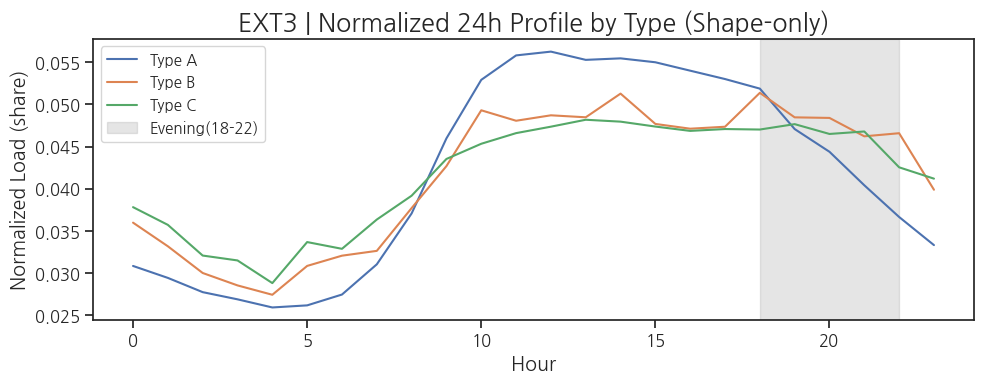

In [37]:
# gu_hourly: [GU_NM, hour, avg_load] 가 이미 있다면 그대로 사용
gu_typed = gu_hourly.merge(gu[["GU_NM","ABC_type"]], on="GU_NM", how="left")

# 타입별 평균 24h 프로파일
type_profile = (
    gu_typed.groupby(["ABC_type","hour"])["avg_load"]
            .mean()
            .reset_index()
)

# 타입별로 정규화 (각 타입의 24h 합으로 나눔)
type_profile["norm_load"] = type_profile.groupby("ABC_type")["avg_load"].transform(lambda s: s / s.sum())

plt.figure(figsize=(10,4))
for t in ["A","B","C"]:
    temp = type_profile[type_profile["ABC_type"] == t]
    plt.plot(temp["hour"], temp["norm_load"], label=f"Type {t}")

plt.axvspan(18, 22, color="gray", alpha=0.2, label="Evening(18-22)")
plt.xlabel("Hour")
plt.ylabel("Normalized Load (share)")
plt.title("EXT3 | Normalized 24h Profile by Type (Shape-only)")
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_8964\3226336895.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["A","B","C"])


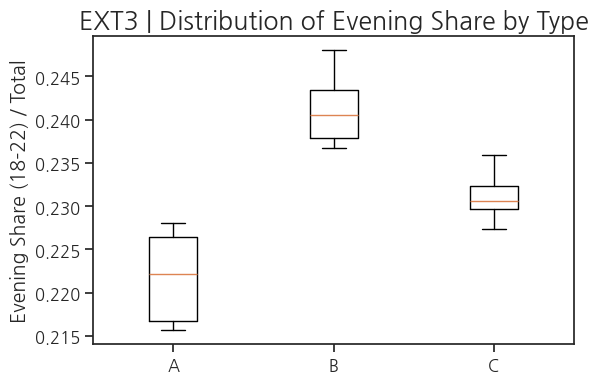

In [38]:
data = [gu.loc[gu["ABC_type"]==t, "evening_share"].dropna().values for t in ["A","B","C"]]

plt.figure(figsize=(6,4))
plt.boxplot(data, labels=["A","B","C"])
plt.ylabel("Evening Share (18-22) / Total")
plt.title("EXT3 | Distribution of Evening Share by Type")
plt.tight_layout()
plt.show()